In [1]:
import numpy as np
import pandas as pd
import numba
import sklearn.datasets
import pynndescent
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.sparse
import sklearn.metrics
from matplotlib import pyplot
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.gridspec import GridSpec
from joblib import Parallel, delayed
from time import time, ctime


from collections import namedtuple
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit

sns.set(rc={"figure.figsize":(12, 12)})

# Load HighDimClusterer class

In [2]:
execfile('00-HighDimClusterer.py')

/work/home/vmpouli/.conda/envs/prob_high_d_clustering/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Experiments

We'll run this algorithm (with tuned parameters) and compare it with a combination of UMAP and HDBSCAN (with tuned parameters). This algorithm was developed largely against MNIST, so it is perhaps somewhat overtuned to MNIST. You may want to substitute in your own favourite dataset instead; alhtough it should be "high dimensional" enough the not require Gamma distribution models (above about 10 should probably be enough).

In [3]:
mnist = sklearn.datasets.fetch_openml("mnist_784")

/work/home/vmpouli/.conda/envs/prob_high_d_clustering/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Parallel hyperparam search

In [4]:
def test_harness(param_dict, train_size, replications=5):
    results_list = []
    parameters = param_dict
    ss = StratifiedShuffleSplit(n_splits=replications, train_size=train_size, random_state=42)
    for i, (train_index, test_index) in enumerate(ss.split(X, y)): 
        clusterer = HighDimClusterer(**parameters)
        start = time()
        cluster_labels = clusterer.fit_predict(X[train_index,:])
        results = parameters.copy()
        results['iteration'] = i
        results['train_size'] = train_size
        results['duration'] = time()-start
        results['adj_rand'] = sklearn.metrics.adjusted_rand_score(cluster_labels, y[train_index])
        non_noise_index = cluster_labels!= -1
        results['adj_rand_no_noise'] = sklearn.metrics.adjusted_rand_score(cluster_labels[non_noise_index], y[train_index][non_noise_index])
        results['number_of_clusters'] = len(np.unique(cluster_labels))
        results['proportion_of_noise'] = np.sum(cluster_labels==-1)/len(cluster_labels)
        results_list.append(results)
    return results_list

In [5]:
from sklearn.model_selection import ShuffleSplit

In [6]:
def test_harness_random(param_dict, train_size, replications=5):
    results_list = []
    parameters = param_dict
    ss = ShuffleSplit(n_splits=replications, train_size=train_size, random_state=42)
    for i, (train_index, test_index) in enumerate(ss.split(X)): 
        clusterer = HighDimClusterer(**parameters)
        start = time()
        cluster_labels = clusterer.fit_predict(X[train_index,:])
        results = parameters.copy()
        results['iteration'] = i
        results['train_size'] = train_size
        results['duration'] = time()-start
        results['adj_rand'] = sklearn.metrics.adjusted_rand_score(cluster_labels, y[train_index])
        non_noise_index = cluster_labels!= -1
        results['adj_rand_no_noise'] = sklearn.metrics.adjusted_rand_score(cluster_labels[non_noise_index], y[train_index][non_noise_index])
        results['number_of_clusters'] = len(np.unique(cluster_labels))
        results['proportion_of_noise'] = np.sum(cluster_labels==-1)/len(cluster_labels)
        results_list.append(results)
    return results_list

In [16]:
def test_harness_cv(param_dict, train_size, replications=5):
    results_list = []
    parameters = param_dict
    ss = ShuffleSplit(n_splits=replications, train_size=train_size, random_state=42)
    for i, (train_index, test_index) in enumerate(ss.split(X)): 
        clusterer = HighDimClusterer(**parameters)
        start = time()
        cluster_labels = clusterer.fit_predict(X[train_index,:])
        results = dict()
        results['iteration'] = i
        results['test_index'] = test_index
        results['duration'] = time()-start
        results['adj_rand'] = sklearn.metrics.adjusted_rand_score(cluster_labels, y[train_index])
        non_noise_index = cluster_labels!= -1
        results['adj_rand_no_noise'] = sklearn.metrics.adjusted_rand_score(cluster_labels[non_noise_index], y[train_index][non_noise_index])
        results['number_of_clusters'] = len(np.unique(cluster_labels)-1)
        results['cluster_labels'] = cluster_labels
        results['proportion_of_noise'] = np.sum(cluster_labels==-1)/len(cluster_labels)
        results_list.append(results)
    return results_list

In [12]:
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed

In [9]:
param_dict = {
    'n_neighbors': [30],
    'min_cluster_size': [800],
    'min_prob': [1e-4],
    'k': [1],
    'model_prior_strength':[0.0],
    'n_iter':[3],
    'max_iter':[50],
    'label_prior': [0.9],
    'noise_prior': [0.1],
    'max_total_weight':[64.0],
    'tolerance':[1e-5],
}
param_list = ParameterGrid(param_dict)
len(param_list)

1

In [10]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.')

In [21]:
%%time
numba.set_num_threads(1)
cores = 4
reps= 30
X = np.array(mnist.data)
y = np.array(mnist.target)
train_sizes=[0.9] 

results_list = []
for train_size in train_sizes:
    total_runs = len(param_list)*reps
    start_time = time()
    results_list.append(list(np.concatenate(Parallel(n_jobs=cores)(delayed(test_harness_cv)(param, train_size, replications=reps) for param in param_list))))
    result_df = pd.DataFrame(list(np.concatenate(results_list)))
    # result_df.to_csv(f"HyperParameterSearch_standardParams_train_size{train_size}_.csv", index=False)
    wall_time = time()-start_time
    total_runs = len(param_list)*reps
    print(f'train size = {train_size}, n_runs = {total_runs} done in {wall_time:.3f} seconds on {cores} cores, time per run={(total_runs/wall_time):0.3f}')

train size = 0.9, n_runs = 30 done in 179.847 seconds on 4 cores, time per run=0.167
CPU times: user 198 ms, sys: 245 ms, total: 443 ms
Wall time: 3min


In [22]:
result_df

,iteration,test_index,duration,adj_rand,adj_rand_no_noise,number_of_clusters,cluster_labels,proportion_of_noise
0,0,"[46730, 48393, 41416, 34506, 43725, 11615, 246...",27.270947,0.883350,0.912246,11,"[9, 4, 2, 9, 5, 5, 3, 0, 5, 4, 5, 1, 0, 7, 3, ...",0.025460
1,1,"[65379, 18677, 50509, 61899, 21301, 53542, 670...",4.573297,0.882064,0.911467,11,"[6, 2, 2, 6, 9, 2, 5, 6, 9, 0, 5, 7, 5, 1, 0, ...",0.025889
2,2,"[8516, 55400, 41490, 13402, 66098, 12052, 4929...",4.570251,0.884560,0.913907,11,"[5, 6, 2, 1, 2, 4, 8, 2, 8, 4, 0, 3, 8, 9, 8, ...",0.025794
3,3,"[53213, 47015, 35629, 19602, 25811, 24029, 401...",4.940858,0.878878,0.909138,11,"[9, 7, 2, 0, 0, 5, 8, 4, 6, 4, 9, 8, 5, 6, 3, ...",0.026683
4,4,"[22036, 22103, 21995, 17398, 53682, 41377, 312...",4.628011,0.889210,0.919549,11,"[9, 8, 1, 1, 9, 2, 8, 5, 9, 9, 8, 7, 0, 8, 9, ...",0.026460
5,5,"[3437, 25216, 23510, 57088, 53293, 19084, 2537...",5.090922,0.884413,0.912735,11,"[8, 3, 5, 7, 3, 4, 3, 4, 6, -1, 4, 7, 8, 4, 5,...",0.024984
6,6,"[8113, 6221, 53142, 54159, 11527, 55327, 57504...",4.811244,0.888106,0.917746,11,"[7, 2, 9, 1, 5, 4, 8, 6, 3, 2, 6, 0, 0, 4, 0, ...",0.025937
7,7,"[1642, 9576, 8285, 43703, 57396, 56022, 36159,...",5.016008,0.879846,0.908655,11,"[2, 2, 3, 6, 4, -1, 1, 2, 7, 2, 3, 7, 2, 7, 0,...",0.025492
8,8,"[27166, 49333, 26817, 65535, 30779, 65655, 671...",5.029874,0.890175,0.919752,11,"[4, 6, 7, 3, 6, 6, 7, 0, 1, 1, -1, 3, 9, 7, 4,...",0.025825
9,9,"[728, 60088, 10424, 61718, 66936, 64689, 15576...",4.943673,0.846847,0.878495,12,"[10, 8, 8, 8, 7, 2, 3, 5, 8, 7, 10, 8, 6, 2, 3...",0.027952


In [56]:
result_df.test_index

0     [46730, 48393, 41416, 34506, 43725, 11615, 246...
1     [65379, 18677, 50509, 61899, 21301, 53542, 670...
2     [8516, 55400, 41490, 13402, 66098, 12052, 4929...
3     [53213, 47015, 35629, 19602, 25811, 24029, 401...
4     [22036, 22103, 21995, 17398, 53682, 41377, 312...
5     [3437, 25216, 23510, 57088, 53293, 19084, 2537...
6     [8113, 6221, 53142, 54159, 11527, 55327, 57504...
7     [1642, 9576, 8285, 43703, 57396, 56022, 36159,...
8     [27166, 49333, 26817, 65535, 30779, 65655, 671...
9     [728, 60088, 10424, 61718, 66936, 64689, 15576...
10    [64456, 3235, 42669, 26132, 14660, 15690, 6564...
11    [32719, 12056, 166, 29638, 64314, 36377, 55340...
12    [64035, 60097, 41094, 16921, 31381, 65757, 231...
13    [10176, 17690, 12643, 1572, 58227, 55118, 5079...
14    [8389, 25064, 45077, 57244, 69028, 40375, 6141...
15    [37114, 4434, 24626, 33160, 60948, 69470, 6337...
16    [51861, 57211, 14644, 48332, 46195, 5179, 1742...
17    [763, 25576, 58890, 37172, 62255, 63629, 4

In [25]:
import umap

In [26]:
%%time
mnist_umap = umap.UMAP(min_dist=0.25).fit_transform(mnist.data)

CPU times: user 1min 31s, sys: 2.23 s, total: 1min 33s
Wall time: 41.7 s


In [29]:
print(result_df.number_of_clusters[9])
result_df.test_index[9]

12


array([  728, 60088, 10424, ..., 17297,  5254, 68782])

In [35]:
new_labels = result_df.cluster_labels[w]

In [36]:
new_labels[0:6]

array([10,  8,  8,  8,  7,  2])

In [45]:
sort_test

array([    7,    17,    18, ..., 69972, 69998, 69999])

In [51]:
w = 9
sort_test = np.sort(result_df.test_index[w])
new_labels = list(result_df.cluster_labels[w])
for i in sort_test:
    new_labels0 = new_labels[0:i] + [-5] + new_labels[i:]
    new_labels = new_labels0
new_labels = np.array(new_labels)

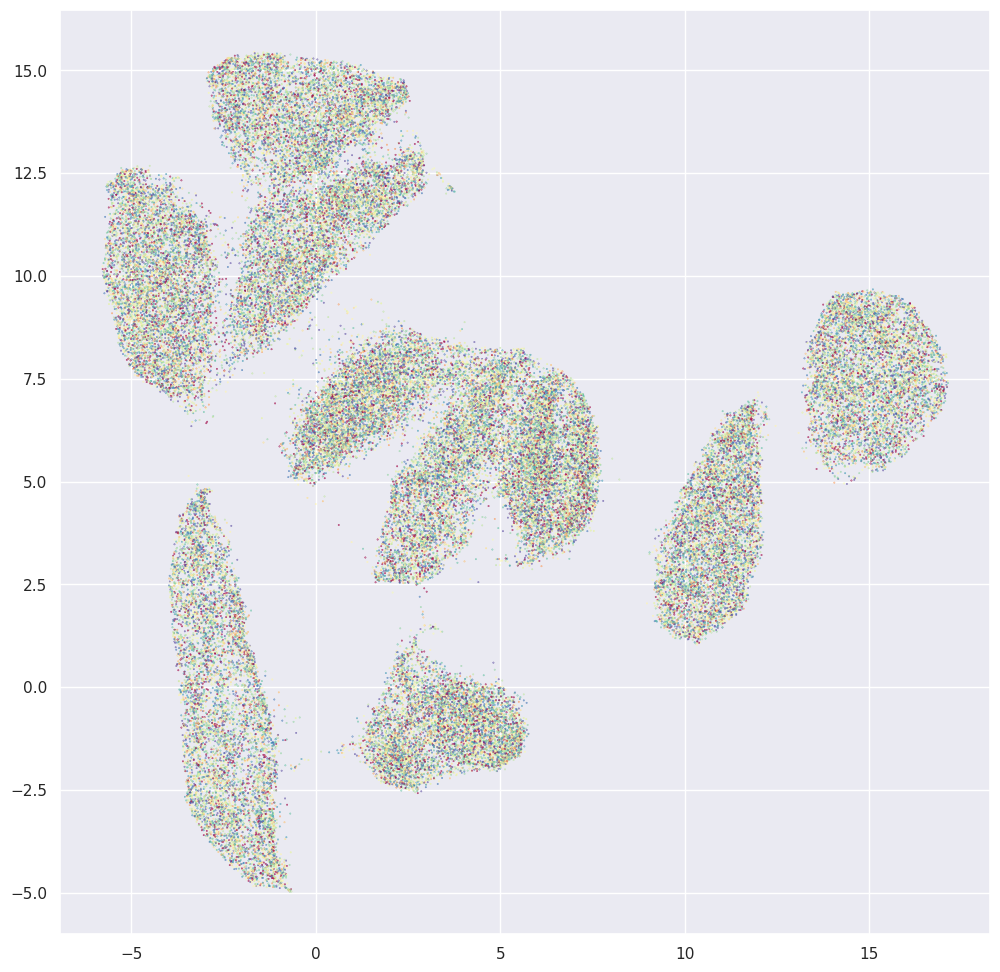

In [52]:
plt.scatter(*mnist_umap.T, s=0.1, c=new_labels.astype(np.int8), cmap="Spectral")

In [31]:
df = pd.DataFrame(result_df)

<Axes: >

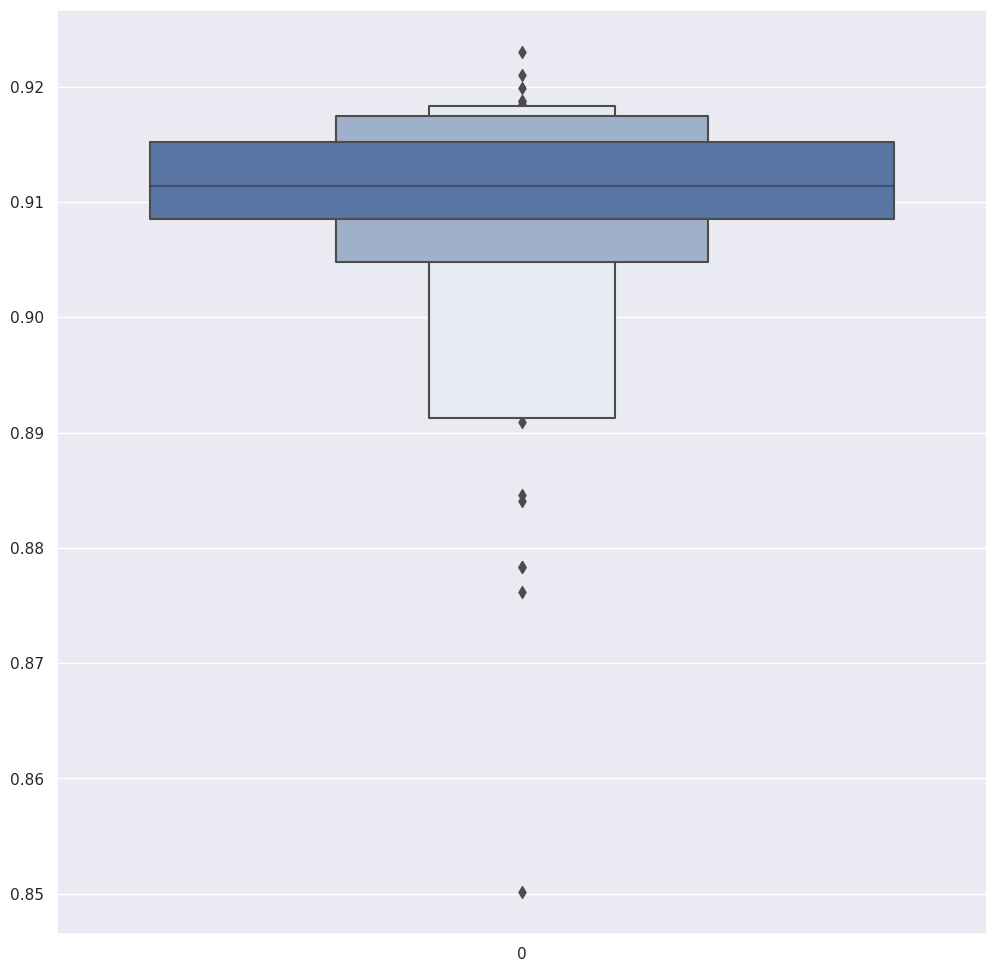

In [33]:
sns.boxenplot(df.adj_rand_no_noise)

In [ ]:
type(wall_time)

In [ ]:
%%time
numba.set_num_threads(1)
cores = 4
reps= 100
X = np.array(mnist.data)
y = np.array(mnist.target)
train_sizes=[0.9] 

results_list_ss = []
for train_size in train_sizes:
    total_runs = len(param_list)*reps
    start_time = time()
    results_list_ss.append(list(np.concatenate(Parallel(n_jobs=cores)(delayed(test_harness_random)(param, train_size, replications=reps) for param in param_list))))
    result_df = pd.DataFrame(list(np.concatenate(results_list_ss)))
    result_df.to_csv(f"HyperParameterSearch_standardParams_shuffleSplit_train_size{train_size}_.csv", index=False)
    wall_time = time()-start_time
    total_runs = len(param_list)*reps
    print(f'train size = {train_size}, n_runs = {total_runs} done in {wall_time:.3f} seconds on {cores} cores, time per run={(total_runs/wall_time):0.3f}')

In [ ]:
print(f'train size = {train_size}, n_runs = {total_runs} done in {wall_time:.3f}')

In [ ]:
result_df.shape

In [ ]:
result_df = pd.DataFrame(list(np.concatenate(results_list)))
result_df.to_csv("HyperParameterSearch_September11_mark2.csv", index=False)

In [ ]:
print(f'runs = {len(result_df)} total time = {wall_time} average time = {wall_time/len(result_df)}')

In [ ]:
12960/(5.5*3600)

In [ ]:
result_df.train_size.value_counts()